### Importacao de Libs Necessárias

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime
import numpy as np
from xgboost import XGBRegressor
import sklearn.model_selection as ms
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
import shap




### Funções Auxiliares para trabalhar com Data Frame Específico


In [16]:

def create_perc_field(df,field_name):
    for delay in ['_d5','_d4','_d3','_d2','_d1','']:
        df['var_perc_'+field_name+delay]= round( (df[field_name+delay].astype(float)-df[field_name+'_d6'].astype(float))/ df[field_name+delay].astype(float) ,6)
 
    return df

def drop_columns(df,col_pref):
    to_drop = [idx for idx in df.columns if idx.startswith(col_pref)]
    df = df.drop(columns = to_drop)

    return df

### Adicionando Infos ao Set Inicial e Criando Set que será utilizado em Modelos Individuais de Fundos


In [39]:
base_full = pd.read_csv('base_final_fundos.csv',sep=";",decimal=",")
base_full = base_full.sort_values(['cod_cnpj','date'],ascending = [True,True])

indices = ['selic','bovespa','dolar','dow_30','ipca_15','tx_cambio']
var_perc_indices_d0 = ['var_perc_' +s for s in indices]

#### Criando Colunas de Variacoes Percentuais dos indices
for field in indices:
    base_full = create_perc_field(base_full,field)

#### Criando colunas de Variacoes Percentuais das cotas

base_full = create_perc_field(base_full,'vl_cota')
    
#### Dropando Valor dos Indices em D+0 (Percentual e Normal)
base_analise = base_full.drop(columns = indices)
base_analise = base_analise.drop(columns = var_perc_indices_d0 )


#### Dropando Valor das cotas da analise - Trabalhando Apenas com variações percentuais

base_analise = drop_columns(base_analise,'vl_cota')

##### Dropando Outras colunas adicionais 

base_analise = base_analise.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1','prim_key'])





### Descrição da análise realizada:

##### Utilizaremos o XGBoost para realizar regressões tentando prever a variação percentual do valor cota de fundos de ação em relação ao valor de 6 dias. Serão Realizadas 3 análises:

##### - Regressão utilizando os valores das variações percentuais dos  dias anteriores ( sempre com base no valor da cota há seis dias atrás)
##### - Regressão anterior, excluindo os valores das variações percentuais dos dias anteriores (puramente com base no uso de indicadores)
##### - Rgressão anterior, excluindo os valores brutos dos índices de mercado 


##### Em cada análise iremos dividir a base em 6 folds . Os 5 primeiros serão utilizados em um cross validation, para verificar se não há uma variação muito abrupta do erro médio quadrático. Uma vez validado, o sexto fold será utilizado para métrica de acurácia final do modelo.

##### Além do XGBoost, será utilizad a função RandomizedSearchCV. Ela realiza a estimativa dos melhores parâmetros do XGBoost  dentro uma lista de parâmetros específicos passados, com base num score pré definido. Neste Caso utilizaremos o erro médio quadrático

In [134]:
##### Parametros do XGboost utilizados na análise:

xgb  = XGBRegressor()
params = {'nthread':[4], 
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100]}
clf = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1, scoring='neg_mean_squared_error', n_jobs=10)

### Análise para Fundos de Ações - Análise com Indicadores

##### Filtrando Base, Ordenando por Data e Fazendo a separação de folds 

In [163]:
##### Filtrando Base e Excluindo Colunas que não serão utilizadas
base_analise_model =  base_analise[base_analise['Fundo de Investimento em Ações']==1]
base_analise_model = drop_columns(base_analise_model,'Fundo de')
base_analise_model= base_analise_model.sort_values(['cod_cnpj','date'],ascending = [True,True]).reset_index(drop=True)

base_analise_model= base_analise_model.drop(columns = ['cod_cnpj','date'])

X = base_analise_model.drop(columns=['var_perc_vl_cota'])
X = X.apply(pd.to_numeric)
Y = base_analise_model.pop('var_perc_vl_cota')
Y = Y.apply(pd.to_numeric)

##### Separando a base de validação da base geral

nfolds = 6
cv = ms.KFold(n_splits=nfolds,shuffle= False)
current_fold = 0
indexes = {}
for index_test,index_train in cv.split(X):
    indexes.update({str(current_fold): index_train})
    current_fold+=1
    
##### Separando ultimo fold para validação     

X_validation = X.iloc[indexes['5']]
X_model = X[~X.index.isin(indexes['5'])]

Y_validation = Y.iloc[indexes['5']]
Y_model = Y[~X.index.isin(indexes['5'])]




##### Realizando Cross Validation do Modelo 

In [164]:
nfolds = 5
cv = ms.KFold(n_splits=nfolds,shuffle= False)
estimators = []
mses = []
train_indexes = {}
current_fold = 0


for train_index, test_index in cv.split(X_model):
    print(current_fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    print("training...")
    clf.fit(X_train, y_train)
    estimators.append(clf.best_estimator_)
    print("Predict...")
    y_pred = clf.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))
    current_fold+=1

0
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
1
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
2
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
3
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
4
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...


##### Resultados do Cross Validation

In [165]:
print('mse: ', mses )
print('valor médio: ',np.mean(mses))
print('desvio padrão: ',np.std(mses))

mse:  [4.608699807025622e-05, 0.00012413965363451538, 0.0006099827035211049, 9.017083211939991e-05, 0.000632887159867734]
valor médio:  0.0003006534694426021
desvio padrão:  0.0002631835694878101


##### Uma vez que tivemos um resultado satisfatório para o cross validation, sem muita variação entre os folds vamos utilizar todos para rodar um modelo final e verificar o seu erro médio quadrático

In [166]:
X_train, X_test = X_model, X_validation
y_train, y_test = Y_model, Y_validation
clf.fit(X_train, y_train)
final_model = clf.best_estimator_
y_pred = clf.predict(X_test)
print('Erro Médio Quadrático Final: ', mean_squared_error(y_test, y_pred))

C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Erro Médio Quadrático Final:  0.00015882360476773727


##### Vamos verificar agora como as variáveis explicam ao modelo. Inicialmente utilizaremos o features_importance do XGBoost

In [167]:
fts_importance = pd.DataFrame(data = np.transpose(np.array([X_validation.columns , final_model.feature_importances_])),
                              columns = ['feature','importance'])
fts_importance = fts_importance.sort_values(by =  'importance' , ascending = False)
fts_importance.head(10)

,feature,importance
77,var_perc_vl_cota_d1,0.355258
76,var_perc_vl_cota_d2,0.0490165
52,var_perc_bovespa_d1,0.0365812
43,var_perc_selic_d5,0.0241613
13,dolar_d2,0.0206933
62,var_perc_dow_30_d1,0.0175119
75,var_perc_vl_cota_d3,0.0167299
22,dow_30_d5,0.0138078
32,tx_cambio_d3,0.0128718
71,var_perc_tx_cambio_d2,0.0123748


#### Agora vamos utilizar o shap para visualizar a importancia dos valores das features no modelo

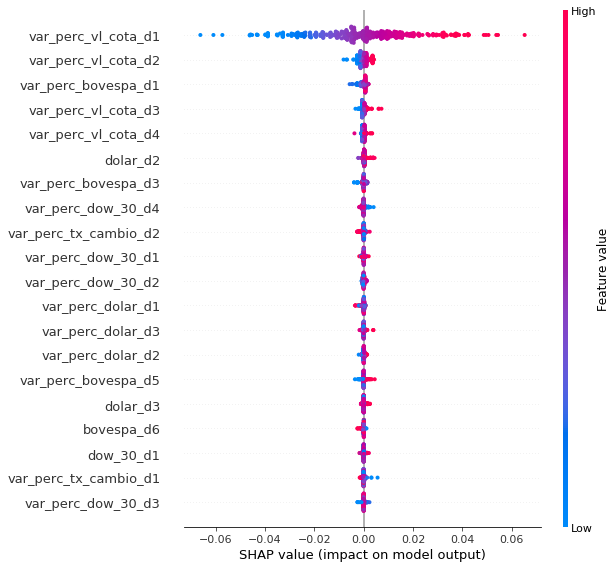

In [168]:
test = X_validation.sample(frac=1)[1:500]
explainer = shap.TreeExplainer(final_model,feature_dependence='independent')
shap_values = explainer.shap_values(test,approximate=True,tree_limit = 50)
shap.summary_plot(shap_values, test)


##### Como pode ser observado, o valor das cotas acaba sendo um preditor muito superior do que o valor do índices propriamente dito. Vamos excluir a mesma do modelo e rodá-lo novamente, com as mesmas premissas:

In [177]:
X_validation,X_model = drop_columns(X_validation,'var_perc_vl_cota'), drop_columns(X_model,'var_perc_vl_cota')

nfolds = 5
cv = ms.KFold(n_splits=nfolds,shuffle= False)
estimators = []
mses = []
train_indexes = {}
current_fold = 0


for train_index, test_index in cv.split(X_model):
    print(current_fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    print("training...")
    clf.fit(X_train, y_train)
    estimators.append(clf.best_estimator_)
    print("Predict...")
    y_pred = clf.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))
    current_fold+=1

print('mse: ', mses )
print('valor médio: ',np.mean(mses))
print('desvio padrão: ',np.std(mses))    

0
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
1
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
2
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
3
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
4
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
mse:  [0.0006404128819901336, 0.00015036978898907164, 4.107624283640904e-05, 5.4869375887070574e-05, 6.515958631669504e-05]
valor médio:  0.00019037757520387594
desvio padrão:  0.00022823904354064603


##### Observe que nenhum dos folds ultrapassa um erro médio quadrático de variação de cota de 0,06%. Temos um preditor razoável , mesmo eliminando os valores das cotas propriamente dito. Vamos agora avaliar o mse final do modelo e a improtância das features

In [178]:
X_train, X_test = X_model, X_validation
y_train, y_test = Y_model, Y_validation
clf.fit(X_train, y_train)
final_model = clf.best_estimator_
y_pred = clf.predict(X_test)
print('Erro Médio Quadrático Final: ', mean_squared_error(y_test, y_pred))

C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Erro Médio Quadrático Final:  0.00035305079506066074


In [179]:
fts_importance = pd.DataFrame(data = np.transpose(np.array([X_model.columns , final_model.feature_importances_])),
                              columns = ['feature','importance'])
fts_importance = fts_importance.sort_values(by =  'importance' , ascending = False)
fts_importance.head(10)

,feature,importance
52,var_perc_bovespa_d1,0.199677
72,var_perc_tx_cambio_d1,0.0394206
51,var_perc_bovespa_d2,0.0324081
31,tx_cambio_d2,0.0270447
50,var_perc_bovespa_d3,0.024132
35,tx_cambio_d6,0.0217223
32,tx_cambio_d3,0.0212627
65,var_perc_ipca_15_d3,0.0195698
30,tx_cambio_d1,0.0191584
57,var_perc_dolar_d1,0.0190017


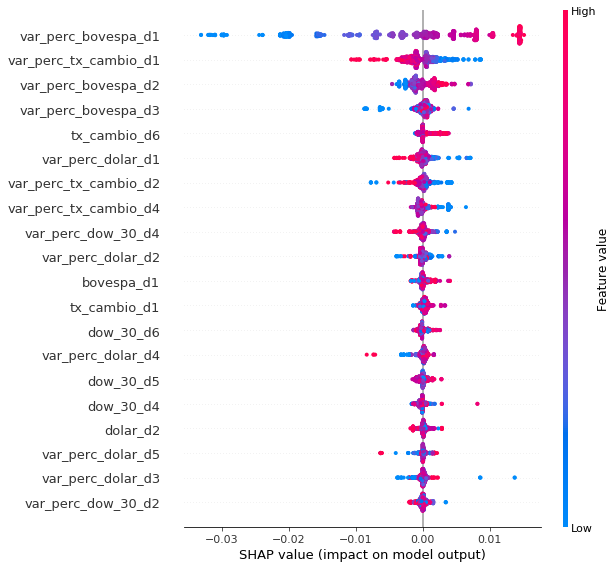

In [181]:
test = X_validation.sample(frac=1)[1:1000]
explainer = shap.TreeExplainer(final_model,feature_dependence='independent')
shap_values = explainer.shap_values(test,approximate=True,tree_limit = 50)
shap.summary_plot(shap_values, test)

##### Temos a variação do valor de bovespa em D-1 e dos valores da taxa de cambio como grandes preditores do modelo. No caso da taxa de câmbio valores negativos do mesmo diminuem o valor da cota dos fundos, ao passo que no caso do bovespa variações positivas no bovespa aumentam o valor da variação percentual da cota. 

##### Vale a pena ressaltar que a variação dos índices é um preditor melhor que o valor do índice propriamente dito. Isso faz sentido, pois o valor da variação dá uma ideia de queda/aumento do indicador, algo que o seu valor absoluto não consegue promover. Hoje 125 mil pontos no ibovespa corresponderia à um record histórico. Daqui a 5 anos, esse valor numa mesma data pode representar uma queda

##### Vamos tentar aprofundar a analisé excluindo os valores brutos dos índices:

In [183]:
for indice in indices:
    X_validation,X_model = drop_columns(X_validation,indice), drop_columns(X_model,indice)

nfolds = 5
cv = ms.KFold(n_splits=nfolds,shuffle= False)
estimators = []
mses = []
train_indexes = {}
current_fold = 0


for train_index, test_index in cv.split(X_model):
    print(current_fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    print("training...")
    clf.fit(X_train, y_train)
    estimators.append(clf.best_estimator_)
    print("Predict...")
    y_pred = clf.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))
    current_fold+=1

print('mse: ', mses )
print('valor médio: ',np.mean(mses))
print('desvio padrão: ',np.std(mses))        

0
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
1
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
2
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
3
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
4
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
mse:  [4.608699807025622e-05, 0.00012493196763827203, 4.200318176276411e-05, 6.531872842333417e-05, 6.515958631669504e-05]
valor médio:  6.870009244226431e-05
desvio padrão:  2.969871940410782e-05


In [184]:
X_train, X_test = X_model, X_validation
y_train, y_test = Y_model, Y_validation
clf.fit(X_train, y_train)
final_model = clf.best_estimator_
y_pred = clf.predict(X_test)
print('Erro Médio Quadrático Final: ', mean_squared_error(y_test, y_pred))

C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Erro Médio Quadrático Final:  0.00037666175580835414


In [185]:
fts_importance = pd.DataFrame(data = np.transpose(np.array([X_model.columns , final_model.feature_importances_])),
                              columns = ['feature','importance'])
fts_importance = fts_importance.sort_values(by =  'importance' , ascending = False)
fts_importance.head(10)

,feature,importance
16,var_perc_bovespa_d1,0.234549
36,var_perc_tx_cambio_d1,0.0611117
15,var_perc_bovespa_d2,0.0546684
34,var_perc_tx_cambio_d3,0.0374101
17,var_perc_dolar_d5,0.0364455
29,var_perc_ipca_15_d3,0.0326045
33,var_perc_tx_cambio_d4,0.0320974
31,var_perc_ipca_15_d1,0.0318745
21,var_perc_dolar_d1,0.0298807
30,var_perc_ipca_15_d2,0.029757


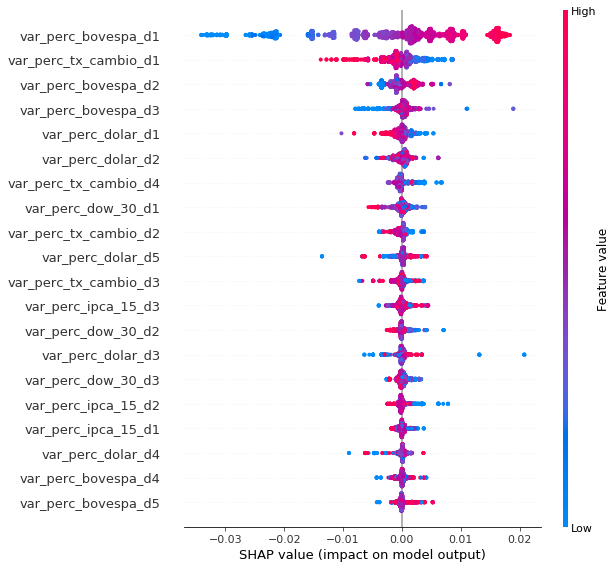

In [186]:
test = X_validation.sample(frac=1)[1:2000]
explainer = shap.TreeExplainer(final_model,feature_dependence='independent')
shap_values = explainer.shap_values(test,approximate=True,tree_limit = 50)
shap.summary_plot(shap_values, test)

##### Podemos observar uma melhora na capacidade preditiva no modelo sem uma mudança brusca na utilização de features do mesmo. Trabalhando apenas com variações percentuais dos indíces e features dos fundos é possível uma predição mais acurada da variação da cota.